In [1]:
import numpy as np
import pandas as pd
import random
import os
from os.path import join
import datetime
import time

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
import numpy as np

def ND(prediction, Y, mask=None):
    if mask is None:
        mask = np.array((~np.isnan(Y)).astype(int))
    Y[mask == 0] = 0.
    return abs((prediction - Y) * mask).sum() / abs(Y).sum()

def NRMSE(prediction, Y, mask=None):
    if mask is None:
        mask = np.array((~np.isnan(Y)).astype(int))
    Y[mask == 0] = 0.
    return pow((pow(prediction - Y, 2) * mask).sum(), 0.5) / abs(Y).sum() * pow(mask.sum(), 0.5)

In [3]:
def get_slice(data, T_train, T_test, T_start, normalize=True):
    N = len(data)
    # split on train and test
    train = data[:, T_start:T_start+T_train].copy()
    test = data[:, T_start+T_train:T_start+T_train+T_test].copy()

    # normalize data
    if normalize:
        mean_train = np.array([])
        std_train = np.array([])
        for i in range(len(train)):
            if (~np.isnan(train[i])).sum() == 0:
                mean_train = np.append(mean_train, 0)
                std_train = np.append(std_train, 0)
            else:
                mean_train = np.append(mean_train, train[i][~np.isnan(train[i])].mean())
                std_train = np.append(std_train, train[i][~np.isnan(train[i])].std())
        
        std_train[std_train == 0] = 1.

        train -= mean_train.repeat(T_train).reshape(N, T_train)
        train /= std_train.repeat(T_train).reshape(N, T_train)
        test -= mean_train.repeat(T_test).reshape(N, T_test)
        test /= std_train.repeat(T_test).reshape(N, T_test)
    
    return train, test

def RollingCV(model, data, T_train, T_test, T_step, metric='ND', normalize=True):
    scores = np.array([])
    for T_start in range(0, data.shape[1]-T_train-T_test+1, T_step):
        train, test = get_slice(data, T_train, T_test, T_start, normalize=normalize)
        model.fit(train)
        test_preds = model.predict(T_test)
        if metric == 'ND':
            scores = np.append(scores, ND(test_preds, test))
        if metric == 'NRMSE':
            scores = np.append(scores, NRMSE(test_preds, test))
    return scores

In [4]:
folders = os.listdir('../../history')

def get_filename(foldername, time='day'):
    filename = '{}_{}_1.csv'.format(foldername, time)
    return join('../../history', foldername, time, filename)

# Data preparations

In [36]:
# prepare timeline
start_date = "01/06/2017"  # "01/01/2017"
first_timestamp = 1496275200  # 1483228800
last_timestamp = first_timestamp + 200 * 60 * 60 * 24
timeline = range(first_timestamp, last_timestamp, 60*60*24)
data = pd.DataFrame(data={'TU': timeline})
dict_crypto_name = {}

# join all series for O, C, H, L
for i in range(len(folders)):
    series = pd.read_csv(get_filename(folders[i]), sep=';', decimal=',')[['TU', 'O', 'C', 'H', 'L']]
    name_columns = ['Open price', 'Close price', 'High price', 'Low price']
    for j in range(i*4, (i+1)*4):
        dict_crypto_name[j] = (name_columns[j-i*4], folders[i])
    data = pd.merge(data, series, how='left', on='TU')

# transpose
data = data.values[:, 1:801].T.astype(float)
data.shape

(800, 200)

In [37]:
# save data
np.savetxt('merged_transposed_series.csv', data, delimiter=';')

In [11]:
print("Percentage of missing data = {}%".format(int((np.isnan(data)).sum() / (data.shape[0]*data.shape[1]) * 100)))

Percentage of missing data = 10%


In [12]:
data_interpolated = data.copy()

N, T = data_interpolated.shape
total = 0
for i in range(N):
    start = 0
    end = 0
    move = 'start'
    fill = False

    for t in range(T):
        if (move == 'start') and (np.isnan(data_interpolated[i][start])):
            move = 'end'
            end = start
            if start > 0:
                a = data_interpolated[i][start-1]
            else:
                a = 0
        if (move == 'end') and (~np.isnan(data_interpolated[i][end]) or (end == T-1)):
            b = data_interpolated[i][end]
            fill = True
            
        if fill:
            if np.isnan(b):
                b = 0
            for j in range(start, end):
                total += 1
                data_interpolated[i][j] = a + (j-start)*(b-a)/(end-start)
            fill = False
            move = 'start'
            start = end
            
        if move == 'start':
            start += 1
        else:
            end += 1

data_interpolated[np.isnan(data_interpolated)] = 0.

In [13]:
def draw_plot(true_data, index_to_check, pred_data = []):

    plt.figure(figsize=(15,8))
    plt.plot(true_data, color='blue')
    if len(pred_data) > 0:
        plt.plot(pred_data, color='red')
    plt.title("%s of %s"%dict_crypto_name[index_to_check])

    plt.xlabel('timepoint')
    plt.ylabel('value')

    plt.show()

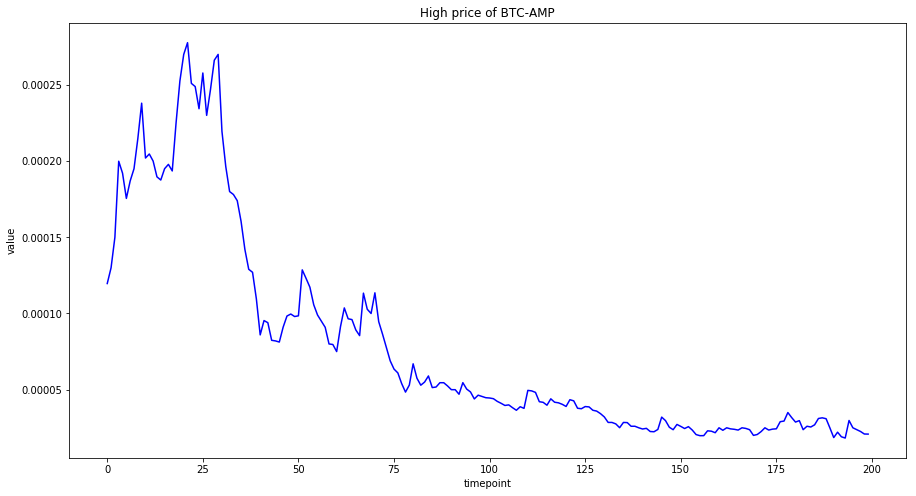

In [267]:
draw_plot(data_interpolated[34],34)

In [14]:
def draw_test_plot(model, index_to_check):

    model.fit(data_interpolated[:,:-20])
    pred_vals = model.predict(20)

    draw_plot(data_interpolated[index_to_check][-20:], index_to_check, pred_data=pred_vals[index_to_check])

# Autoregressive models for each of feature of our dataset.
The most good lags parameter was 1 for such kind of the model, but it works mostly for prediction nearest values (h = 1,5,10), but if we want farther predictions, this model doesn't fit.

In [42]:
class IndependentFeaturesAutoRegressionModel():
    """ Forecasting with n independent AR models for timeseries with lags """
    def __init__(self, lags):
        self.lags = lags

    def fit(self, train):
        self.train = train
        self.coefs = []
        self.intercept = []

        for index in range(len(train)):
            series = train[index]
            features = [np.roll(series, shift=lag+1) for lag in range(self.lags)]
            
            X = np.vstack([features])
            model = LinearRegression()
            model.fit(X[:,self.lags:].T, series[self.lags:])
            self.intercept.append(model.intercept_)
            self.coefs.append(model.coef_)

    def predict(self, h):
        preds = []
        for index in range(len(self.train)):
            series = self.train[index]
            for _ in range(h):
                features = np.array([series[-(lag+1)] for lag in range(self.lags)])
                pred = (self.coefs[index] * features).sum() + self.intercept[index]
                series = np.append(series, pred)
            preds.append(series[-h:])
        return np.vstack(preds)

In [45]:
errors_ind_ar = []
for lags in [1, 7, 14, 30]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = IndependentFeaturesAutoRegressionModel(lags)
        scores_nd = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='ND')
        scores_nrmse = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='NRMSE')
        print('Independent AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h,lags, round(np.array(scores_nd).mean(),3),\
                                                                   round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_ind_ar.append(temp)

Independent AR performance ND/NRMSE (h = 1, lags = 1): 0.129/0.263
Independent AR performance ND/NRMSE (h = 5, lags = 1): 0.273/0.498
Independent AR performance ND/NRMSE (h = 10, lags = 1): 0.399/0.792
Independent AR performance ND/NRMSE (h = 20, lags = 1): 15.812/1023.406
Independent AR performance ND/NRMSE (h = 1, lags = 7): 0.268/4.13
Independent AR performance ND/NRMSE (h = 5, lags = 7): 1.028/27.888
Independent AR performance ND/NRMSE (h = 10, lags = 7): 2224.408/150237.754
Independent AR performance ND/NRMSE (h = 20, lags = 7): 4840.866/403773.829
Independent AR performance ND/NRMSE (h = 1, lags = 14): 3318.347/93853.094
Independent AR performance ND/NRMSE (h = 5, lags = 14): 1064.504/36950.825
Independent AR performance ND/NRMSE (h = 10, lags = 14): 7230.383/500212.725
Independent AR performance ND/NRMSE (h = 20, lags = 14): 10580.527/745719.893
Independent AR performance ND/NRMSE (h = 1, lags = 30): 29212606776.032/754481446748.01
Independent AR performance ND/NRMSE (h = 5, lag

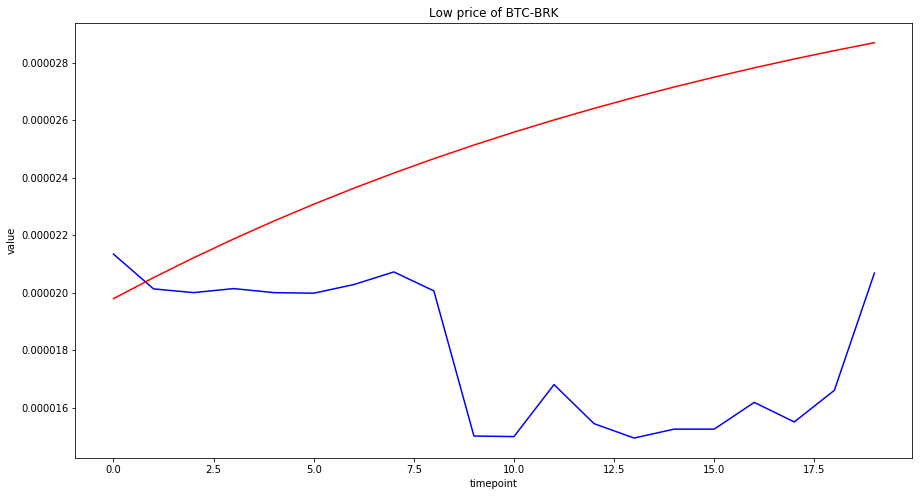

In [44]:
draw_test_plot(IndependentFeaturesAutoRegressionModel(1), 95)

# Autoregressive model for all taken features together
The result showed that with increasing lags number we have better accuracy. 

In [47]:
from statsmodels.tsa.vector_ar.var_model import VAR

class AutoRegressionModel():
    """ Forecasting with AR model for each timeseries with lags """
    def __init__(self, lags):
        self.lags = lags

    def fit(self, train):
        self.train = train.T
        self.model = VAR(endog=self.train)
        self.model_fit = self.model.fit(maxlags=self.lags, trend='nc')

    def predict(self, h):
        res = self.model_fit.forecast(self.model_fit.y[-self.model_fit.k_ar:,:], steps=h)
        return res.T

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [421]:
errors_ar = []
for lags in [1,7,14,30]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = AutoRegressionModel(lags)
        scores_nd = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='ND')
        scores_nrmse = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='NRMSE')
        print('AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h,lags, round(np.array(scores_nd).mean(),3),\
                                                               round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_ar.append(temp)

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


AR performance ND/NRMSE (h = 1, lags = 1): 1.563/1.978
AR performance ND/NRMSE (h = 5, lags = 1): 1.607/2.002
AR performance ND/NRMSE (h = 10, lags = 1): 1.65/2.031
AR performance ND/NRMSE (h = 20, lags = 1): 1.712/2.351
AR performance ND/NRMSE (h = 1, lags = 7): 0.176/0.291
AR performance ND/NRMSE (h = 5, lags = 7): 0.447/0.642
AR performance ND/NRMSE (h = 10, lags = 7): 0.776/1.136
AR performance ND/NRMSE (h = 20, lags = 7): 1.413/2.28
AR performance ND/NRMSE (h = 1, lags = 14): 0.153/0.273
AR performance ND/NRMSE (h = 5, lags = 14): 0.324/0.496
AR performance ND/NRMSE (h = 10, lags = 14): 0.489/0.761
AR performance ND/NRMSE (h = 20, lags = 14): 0.823/1.6
AR performance ND/NRMSE (h = 1, lags = 30): 0.127/0.252
AR performance ND/NRMSE (h = 5, lags = 30): 0.264/0.441
AR performance ND/NRMSE (h = 10, lags = 30): 0.389/0.657
AR performance ND/NRMSE (h = 20, lags = 30): 0.568/1.336


C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


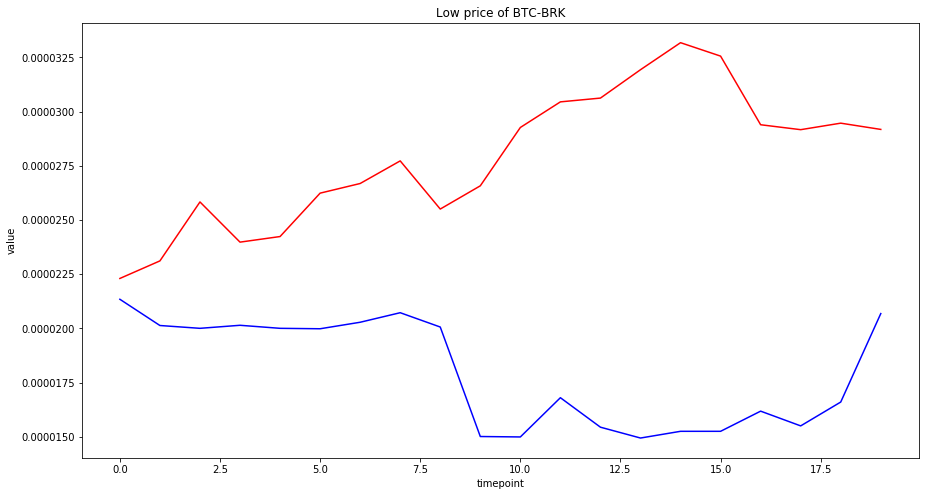

In [49]:
draw_test_plot(AutoRegressionModel(30), 95)

# Autoregressive model for each cryptocurrency (4 crypto features are taken together)
The results showed that this model doesn't converge, and accuracy is bad (probably I have an error)

In [57]:
from statsmodels.tsa.vector_ar.var_model import VAR

class OneCryptoFeaturesAutoRegressionModel():
    """ Forecasting with AR model for each crypto by features with lags """
    def __init__(self, lags, offset_features):
        self.lags = lags
        self.offset_features = offset_features

    def fit(self, train):
        self.n_models = []
        for crypto_num in range(train.shape[0]//self.offset_features):
            train_part = train[crypto_num*self.offset_features:(crypto_num+1)*self.offset_features].T
            model = VAR(endog=train_part)
            model_fit = model.fit(maxlags=self.lags, trend='nc')
            self.n_models.append(model_fit)

    def predict(self, h):
        res_total = []
        for model in self.n_models:
            res_total.append(model.forecast(model.y[-model.k_ar:,:], steps=h))
        return np.hstack(res_total).T

In [59]:
m = OneCryptoFeaturesAutoRegressionModel(1,4)
m.fit(np.asarray([[1,2,3,4],[2,3,4,5],[3,4,5,6],[7,8,9,10]]))
m.predict(3)

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


array([[ 5.38554217,  6.6626506 ,  7.8313253 ],
       [ 6.27710843,  7.44578313,  8.5060241 ],
       [ 7.1686747 ,  8.22891566,  9.18072289],
       [10.73493976, 11.36144578, 11.87951807]])

In [423]:
errors_crypto_ar = []
for lags in [1,7,14,30]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = OneCryptoFeaturesAutoRegressionModel(lags,4)
        scores_nd = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='ND')
        scores_nrmse = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='NRMSE')
        print('One crypto info AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h, lags, round(np.array(scores_nd).mean(),3),\
                                                               round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_crypto_ar.append(temp)

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


One crypto info AR performance ND/NRMSE (h = 1, lags = 1): 70.073/637.585
One crypto info AR performance ND/NRMSE (h = 5, lags = 1): 248.166/2604.522
One crypto info AR performance ND/NRMSE (h = 10, lags = 1): 1.9470909039903637e+56/8.429712928633124e+57
One crypto info AR performance ND/NRMSE (h = 20, lags = 1): 1.0070161160381616e+116/6.246895757260442e+117
One crypto info AR performance ND/NRMSE (h = 1, lags = 7): 2629110101.717/44800343320.156
One crypto info AR performance ND/NRMSE (h = 5, lags = 7): 1.5168513281757456e+28/6.320430826133043e+29
One crypto info AR performance ND/NRMSE (h = 10, lags = 7): 1.4240269932960352e+51/9.026487326109198e+52
One crypto info AR performance ND/NRMSE (h = 20, lags = 7): 9.005603439553501e+107/5.233143721858921e+109
One crypto info AR performance ND/NRMSE (h = 1, lags = 14): 28696451931.343/372192645531.173
One crypto info AR performance ND/NRMSE (h = 5, lags = 14): 3.01262120195044e+32/1.1986587567836703e+34
One crypto info AR performance ND/NR

C:\Users\Asus\Anaconda3_new\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]


One crypto info AR performance ND/NRMSE (h = 20, lags = 30): 1.8566303936920382e+243/inf


C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


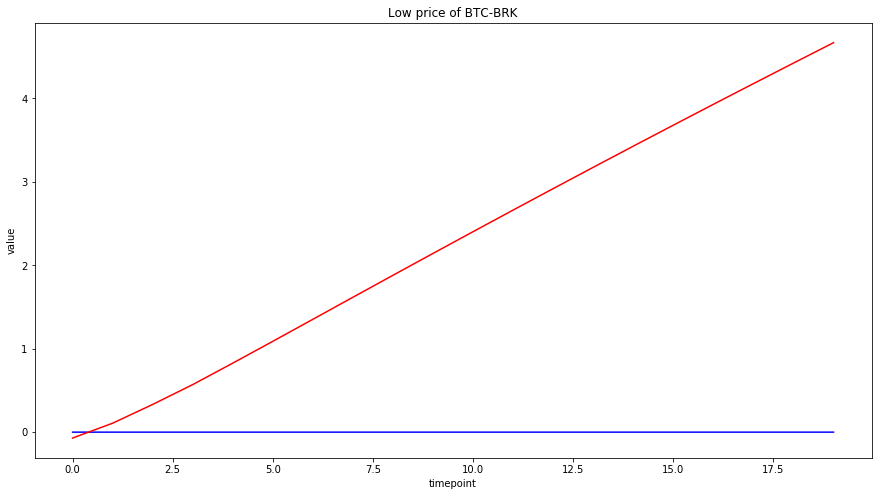

In [56]:
draw_test_plot(OneCryptoFeaturesAutoRegressionModel(1,4), 95)

# Autoregression model with prior SVD dimension reduction for all features together
The results showed worse accuracy that just Autoregressive model, but with increasing number of lags considered accuracy is improving.

In [404]:
from statsmodels.tsa.vector_ar.var_model import VAR

class SvdAutoRegressionModel():
    """ Forecasting with AR model for each crypto by features with lags """
    def __init__(self, lags):
        self.lags = lags
    
    def fit(self, train):
        u, s, vh = np.linalg.svd(train, full_matrices=False)
        self.F = u*s
        self.V = vh
        self.model = VAR(endog=self.V)
        self.model_fit = self.model.fit(maxlags=self.lags, trend='nc')

    def predict(self, h):
        res = self.model_fit.forecast(self.model_fit.y[-self.model_fit.k_ar:,:], steps=h)
        res = np.dot(self.F,res.T)
        return res

In [425]:
errors_svd_ar = []
for lags in [1,7,14,30]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = SvdAutoRegressionModel(lags)
        scores_nd = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='ND')
        scores_nrmse = RollingCV(model, data_interpolated, T-9-h, h, T_step=1, metric='NRMSE')
        print('SVD AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h, lags, round(np.array(scores_nd).mean(),3),\
                                                               round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_svd_ar.append(temp)

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


SVD AR performance ND/NRMSE (h = 1, lags = 1): 3.805/4.199
SVD AR performance ND/NRMSE (h = 5, lags = 1): 3.398/3.96
SVD AR performance ND/NRMSE (h = 10, lags = 1): 3.206/3.764
SVD AR performance ND/NRMSE (h = 20, lags = 1): 3.125/3.844
SVD AR performance ND/NRMSE (h = 1, lags = 7): 1.294/1.442
SVD AR performance ND/NRMSE (h = 5, lags = 7): 1.289/1.469
SVD AR performance ND/NRMSE (h = 10, lags = 7): 1.281/1.503
SVD AR performance ND/NRMSE (h = 20, lags = 7): 1.242/1.849
SVD AR performance ND/NRMSE (h = 1, lags = 14): 1.108/1.241
SVD AR performance ND/NRMSE (h = 5, lags = 14): 1.102/1.266
SVD AR performance ND/NRMSE (h = 10, lags = 14): 1.093/1.313
SVD AR performance ND/NRMSE (h = 20, lags = 14): 1.09/1.704
SVD AR performance ND/NRMSE (h = 1, lags = 30): 1.023/1.155
SVD AR performance ND/NRMSE (h = 5, lags = 30): 1.023/1.185
SVD AR performance ND/NRMSE (h = 10, lags = 30): 1.022/1.245
SVD AR performance ND/NRMSE (h = 20, lags = 30): 1.022/1.645


C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


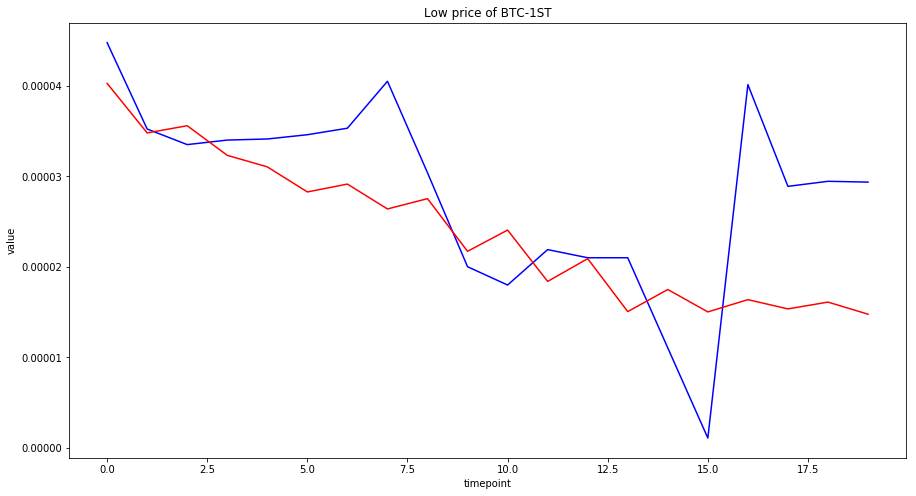

In [426]:
draw_test_plot(SvdAutoRegressionModel(14), 3)

# Simple TRMF model

The results so far worse than Autoregressive model because of algorithm's simpleness and small number of iterations.

In [16]:
from trmf import TRMF

lags = [1, 7, 14, 30]
rank = 256
lambda_f = 0.001
lambda_x = 0.01
lambda_w = 0.0001
alpha = 1000.
eta = 0.
num_iter = 200

In [15]:
for h in [1, 5, 10, 20]:
    model = TRMF(lags, rank, lambda_f, lambda_x, lambda_w, alpha, eta, num_iter)
    scores_nd = RollingCV(model, data, T - 9 - h, h, T_step=1, metric='ND')
    scores_nrmse = RollingCV(model, data, T - 9 - h, h, T_step=1, metric='NRMSE')
    print('TRMF performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(), 3), \
                                                             round(np.array(scores_nrmse).mean(), 3)))

TRMF performance ND/NRMSE (h = 1): 0.893/1.101
TRMF performance ND/NRMSE (h = 5): 0.844/1.221
TRMF performance ND/NRMSE (h = 10): 0.83/1.263
TRMF performance ND/NRMSE (h = 20): 0.89/3.486


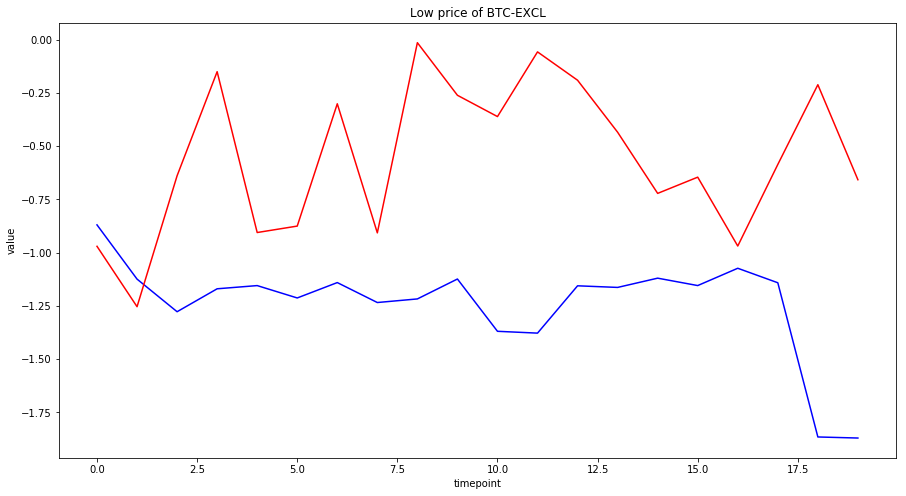

In [17]:
horizon = 20
check_idx = 95
model = TRMF(lags, rank, lambda_f, lambda_x, lambda_w, alpha, eta, 2000)
train, test = get_slice(data, T - 9 - horizon, horizon, 0)
model.fit(train)
predicted_data = model.predict(horizon)
draw_plot(test[check_idx, -horizon:], check_idx, predicted_data[check_idx])